# Project Description:

The purpose of this project is to implement a neural network that performs the translation of mathematical formulae from traditional **infix notation**—where the operator appears between two operands—to **postfix** (also known as Reverse Polish Notation), where the operator follows the operands.

Infix notation is the most commonly used in human-readable mathematics (e.g., a + b), but it is inherently ambiguous without additional syntactic aids such as parentheses or operator precedence rules. This ambiguity arises because different parse trees can correspond to the same expression depending on how operations are grouped.

In contrast, postfix notation eliminates the need for parentheses entirely. The order of operations is explicitly encoded by the position of the operators relative to the operands, making it more suitable for stack-based evaluation and easier to parse programmatically.

**Example:**

Consider the ambiguous infix expression:
a + b * c

This expression can be parsed in at least two different ways:

Interpretation (Infix):	(a + b) * c	   
Equivalent Postfix: ab+c*

Interpretation (Infix):	a + (b * c)	          
Equivalent Postfix: abc*+


This project aims to learn such disambiguations and generate the correct postfix form from a given infix expression using a data-driven approach based on neural networks. To simplify the task and control the complexity of expressions, we restrict our dataset to formulae with a maximum syntactic depth of 3. This means that the abstract syntax trees representing these expressions will have at most three levels, ensuring that the neural network operates on a bounded and manageable set of possible structures.

In [1]:
import numpy as np
import random
import string
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

2025-06-11 17:00:04.192361: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-11 17:00:04.195308: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-11 17:00:04.204530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749654004.220355  192001 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749654004.224825  192001 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749654004.236582  192001 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

We build formulae using 5 identifiers a,b,c,d,e and 4 binary operators +,-,*,/.
For simplicity we do not take advantage of precedence or associativity rules for infix notation, and suppose that all binary operations as always fully parenthesizes: (e1 op e2).

In [2]:
# -------------------- Constants --------------------
OPERATORS = ['+', '-', '*', '/']
IDENTIFIERS = list('abcde')
SPECIAL_TOKENS = ['PAD', 'SOS', 'EOS']
SYMBOLS = ['(', ')', '+', '-', '*', '/']
VOCAB = SPECIAL_TOKENS + SYMBOLS + IDENTIFIERS + ['JUNK'] #may use junk in autoregressive generation

token_to_id = {tok: i for i, tok in enumerate(VOCAB)}
id_to_token = {i: tok for tok, i in token_to_id.items()}
VOCAB_SIZE = len(VOCAB)
PAD_ID = token_to_id['PAD']
EOS_ID = token_to_id['EOS']
SOS_ID = token_to_id['SOS']

MAX_DEPTH = 3
MAX_LEN = 4*2**MAX_DEPTH -2 #enough to fit expressions at given depth (+ EOS)

In [3]:
# -------------------- Expression Generation --------------------
def generate_infix_expression(max_depth):
    if max_depth == 0:
        return random.choice(IDENTIFIERS)
    elif random.random() < 0.5:
        return generate_infix_expression(max_depth - 1)
    else:
        left = generate_infix_expression(max_depth - 1)
        right = generate_infix_expression(max_depth - 1)
        op = random.choice(OPERATORS)
        return f'({left} {op} {right})'

def tokenize(expr):
    return [c for c in expr if c in token_to_id]

def infix_to_postfix(tokens):
    precedence = {'+': 1, '-': 1, '*': 2, '/': 2}
    output, stack = [], []
    for token in tokens:
        if token in IDENTIFIERS:
            output.append(token)
        elif token in OPERATORS:
            while stack and stack[-1] in OPERATORS and precedence[stack[-1]] >= precedence[token]:
                output.append(stack.pop())
            stack.append(token)
        elif token == '(':
            stack.append(token)
        elif token == ')':
            while stack and stack[-1] != '(':
                output.append(stack.pop())
            stack.pop()
    while stack:
        output.append(stack.pop())
    return output

def encode(tokens, max_len=MAX_LEN):
    ids = [token_to_id[t] for t in tokens] + [EOS_ID]
    return ids + [PAD_ID] * (max_len - len(ids))

def decode_sequence(token_ids, id_to_token, pad_token='PAD', eos_token='EOS'):
    """
    Converts a list of token IDs into a readable string by decoding tokens.
    Stops at the first EOS token if present, and ignores PAD tokens.
    """
    tokens = []
    for token_id in token_ids:
        token = id_to_token.get(token_id, '?')
        if token == eos_token:
            break
        if token != pad_token:
            tokens.append(token)
    return ' '.join(tokens)

def generate_dataset(n,max_depth=MAX_DEPTH):
    X, Y = [], []
    for _ in range(n):
        expr = generate_infix_expression(MAX_DEPTH)
        #expr = expr_gen.generate(max_depth=max_dthep)
        infix = tokenize(expr)
        postfix = infix_to_postfix(infix)
        X.append(encode(infix))
        Y.append(encode(postfix))
    return np.array(X), np.array(Y)

#you might use the shift function for teacher-forcing
def shift_right(seqs):
    shifted = np.zeros_like(seqs)
    shifted[:, 1:] = seqs[:, :-1]
    shifted[:, 0] = SOS_ID
    return shifted

Let us define a simple dataset, and inspect a few samples.

In [4]:
X_train, Y_train = generate_dataset(10000)
decoder_input_train = shift_right(Y_train)

# Dataset
X_val, Y_val = generate_dataset(1000)
decoder_input_val = shift_right(Y_val)

In [5]:
i =  np.random.randint(10000)
print(i)
print("infix : ",decode_sequence(X_train[i],id_to_token))
print("posfix notation: ",decode_sequence(Y_train[i],id_to_token))
print("teacher forcing : ", decode_sequence(decoder_input_train[i],id_to_token))

701
infix :  ( d / ( c / c ) )
posfix notation:  d c c / /
teacher forcing :  SOS d c c / /


# Constraints
* You may use any architecture (decoder-only, encoder-decoder, or other).

* The maximum number of parameters is 2 million.

* Beam search is not allowed.

* You may adapt the formula generator to your needs, but preserve its core logic—especially the frequency distribution of formulas by depth, as it may significantly influence model performance.

* You may train your model using a pre-generated fixed dataset (e.g., an array) or directly use an on-the-fly generator.




# Evaluation

We shall evaluate a generated item y_pred using "prefix accuracy", the lenght of
the initial prefix of y_pred matching the ground true y_true. This will be divided by the maximum length of y_true and y_pred (up to EOS), so that a perfect match has score 1.

* It's more informative than exact match (which is often 0)

* It’s tighter than edit distance: focuses on generation flow

* Captures where the model starts to make errors



In [6]:
def prefix_accuracy_single(y_true, y_pred, id_to_token, eos_id=EOS_ID, verbose=False):
    t_str = decode_sequence(y_true, id_to_token).split(' EOS')[0]
    p_str = decode_sequence(y_pred, id_to_token).split(' EOS')[0]
    t_tokens = t_str.strip().split()
    p_tokens = p_str.strip().split()
    max_len = max(len(t_tokens), len(p_tokens))

    match_len = sum(x == y for x, y in zip(t_tokens, p_tokens))
    score = match_len / max_len if max_len>0 else 0

    if verbose:
        print("TARGET :", ' '.join(t_tokens))
        print("PREDICT:", ' '.join(p_tokens))
        print(f"PREFIX MATCH: {match_len}/{len(t_tokens)} → {score:.2f}")

    return score

For the exam, evaluate you model on a test set of 20 expressions. Repeat this evaluation 10 times, and return the mean and std for this rounds.

In [ ]:
class PositionalEncoding(layers.Layer):
    """
    Positional Encoding Layer for adding positional information to input embeddings.
    """

    def __init__(self, max_len, d_model):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len

    def build(self, input_shape):
        # Create positional encoding matrix
        pe = np.zeros((self.max_len, self.d_model))
        position = np.arange(0, self.max_len)[:, np.newaxis]
        div_term = np.exp(
            np.arange(0, self.d_model, 2) * -(np.log(10000.0) / self.d_model)
        )

        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)

        self.pe = self.add_weight(
            name="positional_encoding",
            shape=(self.max_len, self.d_model),
            initializer="zeros",
            trainable=False,
        )
        self.pe.assign(pe)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pe[:seq_len, :]


def create_transformer_model(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    embedding_dim=64,
    num_heads=4,
    feedforward_dimension=128,
    num_layers=2,
):
    """
    Create the Transformer model architecture.
    """

    # Encoder
    encoder_inputs = layers.Input(shape=(max_len,), name="encoder_inputs")

    # Encoder embedding and positional encoding
    encoder_embedding = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(
        encoder_inputs
    )
    encoder_pos_encoding = PositionalEncoding(max_len, embedding_dim)(encoder_embedding)
    encoder_dropout = layers.Dropout(0.1)(encoder_pos_encoding)

    # Encoder layers
    encoder_output = encoder_dropout
    for i in range(num_layers):
        # Multi-head attention
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim // num_heads, dropout=0.1
        )(encoder_output, encoder_output)
        attention_output = layers.Dropout(0.1)(attention_output)
        encoder_output = layers.LayerNormalization()(encoder_output + attention_output)

        # Feed forward
        ffn_output = layers.Dense(feedforward_dimension, activation="relu")(encoder_output)
        ffn_output = layers.Dense(embedding_dim)(ffn_output)
        ffn_output = layers.Dropout(0.1)(ffn_output)
        encoder_output = layers.LayerNormalization()(encoder_output + ffn_output)

    # Decoder
    decoder_inputs = layers.Input(shape=(max_len,), name="decoder_inputs")

    # Decoder embedding and positional encoding
    decoder_embedding = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(
        decoder_inputs
    )
    decoder_pos_encoding = PositionalEncoding(max_len, embedding_dim)(decoder_embedding)
    decoder_dropout = layers.Dropout(0.1)(decoder_pos_encoding)

    # Decoder layers
    decoder_output = decoder_dropout
    for i in range(num_layers):
        # Masked multi-head attention (self-attention)
        self_attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim // num_heads, dropout=0.1
        )(decoder_output, decoder_output, use_causal_mask=True)
        self_attention_output = layers.Dropout(0.1)(self_attention_output)
        decoder_output = layers.LayerNormalization()(
            decoder_output + self_attention_output
        )

        # Cross-attention with encoder
        cross_attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim // num_heads, dropout=0.1
        )(decoder_output, encoder_output)
        cross_attention_output = layers.Dropout(0.1)(cross_attention_output)
        decoder_output = layers.LayerNormalization()(
            decoder_output + cross_attention_output
        )

        # Feed forward
        ffn_output = layers.Dense(feedforward_dimension, activation="relu")(decoder_output)
        ffn_output = layers.Dense(embedding_dim)(ffn_output)
        ffn_output = layers.Dropout(0.1)(ffn_output)
        decoder_output = layers.LayerNormalization()(decoder_output + ffn_output)

    # Output layer
    outputs = layers.Dense(vocab_size, activation="softmax")(decoder_output)

    model = models.Model([encoder_inputs, decoder_inputs], outputs)
    return model


# Create the model
model = create_transformer_model(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    embedding_dim=64,  # embedding dimension
    num_heads=4,  # Number of attention heads
    feedforward_dimension=128,  # Feed-forward dimension
    num_layers=2,  # 2 layers
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

print(f"Total parameters: {model.count_params():,}")
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Max sequence length: {MAX_LEN}")

2025-06-11 17:00:06.043316: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/enrico/Desktop/Infix-to-postfix-notation/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'positional_encoding' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/enrico/Desktop/Infix-to-postfix-notation/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'positional_encoding_1' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Total parameters: 174,159
Vocabulary size: 15
Max sequence length: 30


Training samples: 10000
Validation samples: 10000
Input shape: (10000, 30)
Output shape: (10000, 30)
Decoder input shape: (10000, 30)
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step - accuracy: 0.7863 - loss: 0.6961 - val_accuracy: 0.8476 - val_loss: 0.3403
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.8502 - loss: 0.3429 - val_accuracy: 0.9219 - val_loss: 0.1976
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.9441 - loss: 0.1565 - val_accuracy: 0.9929 - val_loss: 0.0193
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.9854 - loss: 0.0453 - val_accuracy: 0.9971 - val_loss: 0.0093
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.9924 - loss: 0.0249 - val_accuracy: 0.9994 - val_loss: 0.0022
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.9952 - loss: 0.0158 - val_accuracy: 0.9999 - val_loss: 7.9273e-04
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.9960 - loss: 0

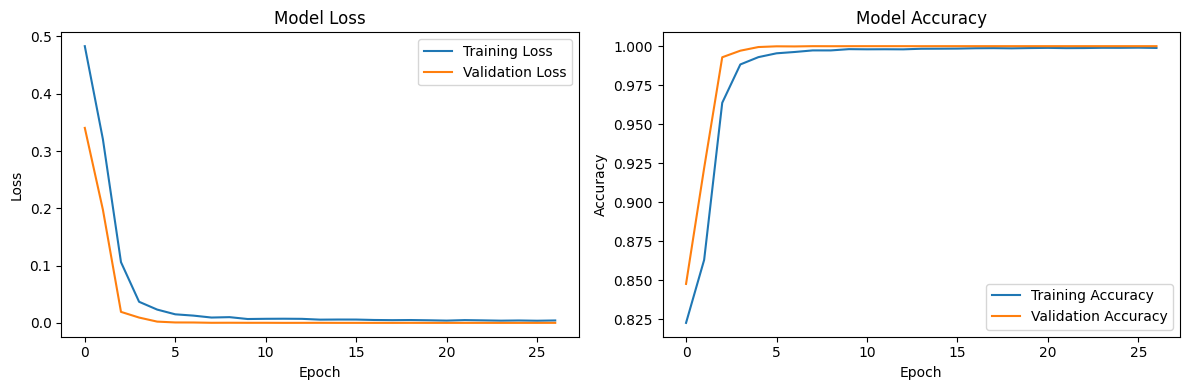

Final training loss: 0.0043
Final validation loss: 0.0001
Final training accuracy: 0.9989
Final validation accuracy: 1.0000


In [8]:
# Prepare training data
batch_size = 32
epochs = 50  # 50 epochs because we use early stopping
MAX_DATASET_SIZE = 10000  # Original size for full training

# Generate smaller dataset for initial testing
X_train, Y_train = generate_dataset(MAX_DATASET_SIZE)
decoder_input_train = shift_right(Y_train)

# Validation dataset
X_val, Y_val = generate_dataset(MAX_DATASET_SIZE)
decoder_input_val = shift_right(Y_val)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Input shape: {X_train.shape}")
print(f"Output shape: {Y_train.shape}")
print(f"Decoder input shape: {decoder_input_train.shape}")

# Display model summary
# model.summary()

# Early stopping callback to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)


LOAD_WEIGHTS = False # If False, proceed to train the model


if LOAD_WEIGHTS:
    model.load_weights("model_weights.weights.h5")
    print("Loaded pre-trained weights.")
else:
    # Train the model
    history = model.fit(
        [X_train, decoder_input_train],
        Y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=([X_val, decoder_input_val], Y_val),
        callbacks=[early_stop],
        verbose=1,
    )


    # Plot training history
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Final training loss: {history.history['loss'][-1]:.4f}")
    print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

In [12]:
SAVE_WEIGHTS = True
# Save weights
if SAVE_WEIGHTS:
    model.save_weights("model_weights.weights.h5")
    print("Model weights saved to 'model_weights.weights.h5'.")

Model weights saved to 'model_weights.weights.h5'.


In [9]:
def autoregressive_decode(model, encoder_input, max_len=MAX_LEN):
    """
    Autoregressively decode a sequence using the trained model.
    """
    encoder_input = np.expand_dims(encoder_input, axis=0)  # shape (1, seq_len)
    decoder_input = np.array([[SOS_ID]])  # start with SOS token

    for _ in range(max_len):
        predictions = model.predict([encoder_input, decoder_input], verbose=0)
        next_token_id = np.argmax(predictions[0, -1, :])  # get last token prediction
        if next_token_id == EOS_ID:  # stop if EOS is generated
            break
        decoder_input = np.append(decoder_input, [[next_token_id]], axis=1)

    return decoder_input[0]  # return as flat array of token IDs


In [10]:
def test(no=20,rounds=10):
  rscores =[]
  for i in range(rounds):
    print("round=",i)
    X_test, Y_test = generate_dataset(no)
    scores = []
    for j in range(no):
      encoder_input=X_test[j]
      generated = autoregressive_decode(model, encoder_input)[1:] #remove SOS
      scores.append(prefix_accuracy_single(Y_test[j], generated, id_to_token))
    rscores.append(np.mean(scores))
  return np.mean(rscores),np.std(rscores)

res, std = test(20,10)
print("score=",res,"std=",std)

round= 0


/home/enrico/Desktop/Infix-to-postfix-notation/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'positional_encoding' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/enrico/Desktop/Infix-to-postfix-notation/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'positional_encoding_1' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/enrico/Desktop/Infix-to-postfix-notation/.venv/lib/python3.12/site-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 4, 1, 1). This axis has size 1. The softmax operati

round= 1
round= 2
round= 3
round= 4
round= 5
round= 6
round= 7
round= 8
round= 9
score= 1.0 std= 0.0


Be sure to evalutate the generator: your model may only take as input the expression in infix format and return its translation to postifix.

If you are usuing an encoder-decoder model, generation must be done autoregressively.

# What to deliver

As usual you are supposed to deliver a single notebook witten in Keras. You are auhtorized to use Keras3 with pytorch as backend if your prefer.

Do no upload a zip file: the submission will be rejected.

The python notebook should have a clear documentation of the training phase, possibly with its history.

You should be able to provide the network paramters upon request. Even better, consider a way to upload them inside your notebook using gdown.